## Solving MQO Problems with a static solutions

Functionality needed to create problems and solutions

In [3]:
from qiskit import *
from qiskit import Aer
from qiskit.circuit import Parameter
from qiskit.visualization import plot_histogram
from qiskit.providers.aer import QasmSimulator

import numpy as np
import math
import random
import csv
import matplotlib.pyplot as plt

from IPython.display import clear_output

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score

In [4]:
def create_savings(n_queries, n_plans, savings_min=-20, savings_max=0):
    savings = {}
    for j in range(n_plans*n_queries):
        current_query = math.floor(j / n_plans)
        first_plan_next_query = (current_query + 1) * n_plans
        for i in range(first_plan_next_query, n_queries*n_plans):
            savings[j, i] = random.randint(savings_min, savings_max)
    return savings

def generate_problems(n_queries, n_plans, size, cost_min=0, cost_max=50):
    problems = []
    for i in range(size):
        problems.append((n_queries, np.random.randint(cost_min, cost_max, int(n_queries*n_plans)), create_savings(n_queries, n_plans)))
    return problems

def extract_values(dataset):
    values = []
    for row in dataset:
        values.append(
            np.concatenate((row[1].tolist(),list(row[2].values())))
            )
    return np.array(values)

def scale_problems(problems, scale_min=-np.pi/4, scale_max=np.pi/4):
    scaled_problems = []
    scaler = MinMaxScaler((scale_min, scale_max))
    for problem in problems:
        scaled_problems.append(scaler.fit_transform(problem.reshape(-1,1)))
    return scaled_problems

def create_solution_set(problems):
    y = []
    y_complete = []
    for problem in problems:
        #### calculate totally cheapest option
        t_cost = []
        t_cost.append([problem[0]+problem[2]+problem[4], problem[0]+problem[3]+problem[5]])
        t_cost.append([problem[1]+problem[2]+problem[6], problem[1]+problem[3]+problem[7]])
        y.append(np.array(t_cost).argmin())
        #### calculate sorted ranking of cost
        t_total = {}
        t_total[0] = problem[0]+problem[2]+problem[4]
        t_total[1] = problem[0]+problem[3]+problem[5]
        t_total[2] = problem[1]+problem[2]+problem[6]
        t_total[3] = problem[1]+problem[3]+problem[7]
        y_complete.append(t_total)
    return y, y_complete

In [5]:
#### Circuit based functions 
def uncertainity_principle(circuit):
    circuit.h(range(circuit.width()))
    circuit.barrier()

def cost_encoding(circuit):
    for i in range(circuit.width()):
        circuit.ry(-Parameter('c'+str(i)), i)
    circuit.barrier()

def same_query_cost(circuit):
    for i in range(0,circuit.width(),2):
        circuit.crz(-np.pi/4,i,i+1)
    circuit.barrier()

def savings_encoding(circuit):
        for i in range(int(circuit.width()/2)):
            circuit.crz(Parameter('s'+str(i)+str(int(circuit.width()/2))), i, int(circuit.width()/2))
            circuit.crz(Parameter('s'+str(i)+str(int(1+circuit.width()/2))), i, int(1+circuit.width()/2))
        circuit.barrier()

def rx_layer(circuit, weight):
    if len(weight) == 1:
        circuit.rx(weight[0], range(circuit.width()))
    else:
        for i, w in enumerate(weight):
            circuit.rx(w, i)
    circuit.barrier()

def create_circuit(n_queries, n_plans, scheme, xweight=np.pi/4):
    circuit = QuantumCircuit(n_queries*n_plans)
    for module in scheme:
        if module == "h":
            uncertainity_principle(circuit)
        elif module == "c":
            cost_encoding(circuit)
        elif module == "s":
            savings_encoding(circuit)
        elif module == "x":
            rx_layer(circuit, [Parameter('w0')])
    return circuit

In [6]:
problems = generate_problems(2, 2, 1000)
problems_values = extract_values(problems)
problems_scaled = scale_problems(problems_values)
solution, complete_solution = create_solution_set(problems_scaled)
circuit = create_circuit(2, 2, 'csx')
print(circuit)

     ┌─────────────┐ ░                                              ░ »
q_0: ┤ Ry(-1.0*c0) ├─░──────■──────────■────────────────────────────░─»
     ├─────────────┤ ░      │          │                            ░ »
q_1: ┤ Ry(-1.0*c1) ├─░──────┼──────────┼──────────■──────────■──────░─»
     ├─────────────┤ ░ ┌────┴────┐     │     ┌────┴────┐     │      ░ »
q_2: ┤ Ry(-1.0*c2) ├─░─┤ Rz(s02) ├─────┼─────┤ Rz(s12) ├─────┼──────░─»
     ├─────────────┤ ░ └─────────┘┌────┴────┐└─────────┘┌────┴────┐ ░ »
q_3: ┤ Ry(-1.0*c3) ├─░────────────┤ Rz(s03) ├───────────┤ Rz(s13) ├─░─»
     └─────────────┘ ░            └─────────┘           └─────────┘ ░ »
«     ┌────────┐ ░ 
«q_0: ┤ Rx(w0) ├─░─
«     ├────────┤ ░ 
«q_1: ┤ Rx(w0) ├─░─
«     ├────────┤ ░ 
«q_2: ┤ Rx(w0) ├─░─
«     ├────────┤ ░ 
«q_3: ┤ Rx(w0) ├─░─
«     └────────┘ ░ 


In [7]:
circuit.parameters[8:]

[Parameter(w0)]

### ML Part

In [8]:
from qiskit_machine_learning.neural_networks import TwoLayerQNN, CircuitQNN
from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier, VQC
from qiskit_machine_learning.algorithms.regressors import NeuralNetworkRegressor, VQR
from qiskit.utils import QuantumInstance
from qiskit.algorithms.optimizers import *
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

In [9]:
#set up gpu
n_shots = 5000

simulator = Aer.get_backend('qasm_simulator')
quantum_instance = QuantumInstance(simulator, shots=n_shots)

In [10]:
output_shape = 4
def parity(x):
    return x % 4

In [11]:

def callback_graph(weights, obj_func_eval):
    clear_output(wait=True)
    objective_func_vals.append(obj_func_eval)
    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()
    model_weights.append(weights)

In [12]:
def fit_and_score(circuit_classifier, features, targets, random_state = 69069):
    X_train, X_test, y_train, y_test = train_test_split(features, targets, test_size=1-3/4, random_state=random_state)
    # fit classifier to data
    X_train = np.array(X_train)
    X_test = np.array(X_test)
    y_train = np.array(y_train)
    y_test = np.array(y_test)
    plt.rcParams["figure.figsize"] = (12, 6)
    circuit_classifier.fit(X_train, y_train)
    # return to default figsize
    plt.rcParams["figure.figsize"] = (6, 4)
    score_train =  circuit_classifier.score(X_train, y_train)
    score_test =  circuit_classifier.score(X_test, y_test)
    print("Mean Accuracy training: " + str(score_train))
    print("Mean Accuracy testing: " + str(score_test))
    return score_train, score_test

def get_classifier(circuit, optimizer):
    circuit_qnn = CircuitQNN(circuit=circuit,    
                         input_params=circuit.parameters[0:8],
                         weight_params=circuit.parameters[8:],
                         interpret=parity,
                         output_shape=output_shape,
                         quantum_instance=quantum_instance)

    # construct classifier
    return NeuralNetworkClassifier(neural_network=circuit_qnn,                                             
                                                optimizer=optimizer,
                                                initial_point=[np.pi/4],
                                                callback=callback_graph)

In [13]:
problems_reorg = []
for a in problems_scaled:
    temp = []
    for b in a:
        temp.append(b[0])
    problems_reorg.append(temp)

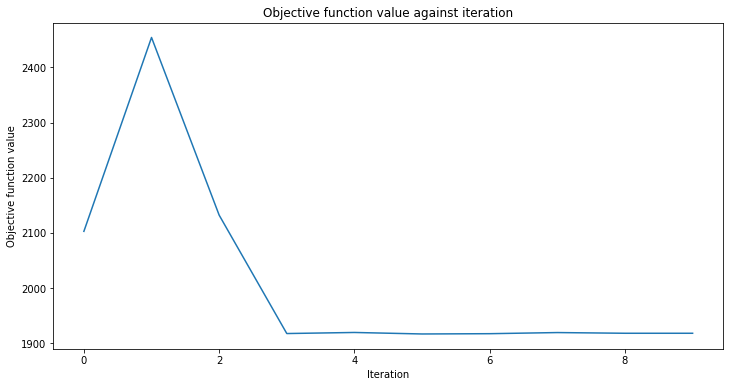

KeyboardInterrupt: 

In [14]:
weights = []
loss_values = []
training_data = []
testing_data = []
max_iterations = 50
optimizers_strings = ['COBYLA','SPSA','POWELL','P_BFGS','L_BFGS_B','NELDER_MEAD','CG']
optimizers = [COBYLA(maxiter=max_iterations), SPSA(maxiter=max_iterations), POWELL(maxiter=max_iterations), ADAM(amsgrad=True, maxiter=max_iterations),
P_BFGS(maxfun=max_iterations), L_BFGS_B(maxiter=max_iterations), NELDER_MEAD(maxiter=max_iterations), CG(maxiter=max_iterations)]
global model_weights
global objective_func_vals
for optimizer in optimizers:
    model_weights = []
    objective_func_vals = []
    classifier = get_classifier(circuit.copy(), optimizer=optimizer)
    score_train, score_test = fit_and_score(classifier, problems_reorg, solution)
    training_data.append(score_train)
    testing_data.append(score_test)
    weights.append(model_weights)
    loss_values.append(objective_func_vals)
    display(print('optimizer done'))